In [1]:
import pandas as pd
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("Dark2")

In [2]:
results = pd.read_parquet("./timing_models_scaling_ttf.gzip")
results

,neuroticism,repetition,step,exec_time,ttf,duration,cumulative_duration,model
0,n/a,1,1,5.366055,0.0,5.366055,5.366055,constant
1,n/a,1,2,5.366055,0.0,5.366055,10.732110,constant
2,n/a,1,3,5.366055,0.0,5.366055,16.098165,constant
3,n/a,1,4,5.366055,0.0,5.366055,21.464219,constant
4,n/a,1,5,5.366055,0.0,5.366055,26.830274,constant
...,...,...,...,...,...,...,...,...
524995,high,30,96,6.727445,5.0,11.727445,1167.474807,theoretical
524996,high,30,97,6.676840,5.0,11.676840,1179.151647,theoretical
524997,high,30,98,5.405427,5.0,10.405427,1189.557075,theoretical
524998,high,30,99,12.670499,5.0,17.670499,1207.227574,theoretical


In [3]:
end_steps = results[(results.step == results.step.max()) & (results.model != "constant")].copy()
end_steps["model"] = end_steps["model"].cat.remove_unused_categories()
end_steps["reference"] = False
end_steps.loc[end_steps["neuroticism"] == "n/a", "reference"] = True
end_steps

,neuroticism,repetition,step,exec_time,ttf,duration,cumulative_duration,model,reference
75099,low,1,100,6.765989,0.0,6.765989,516.196615,empirical,False
75199,low,2,100,2.078182,0.0,2.078182,442.040668,empirical,False
75299,low,3,100,4.028004,0.0,4.028004,463.228406,empirical,False
75399,low,4,100,5.078731,0.0,5.078731,468.080511,empirical,False
75499,low,5,100,2.481269,0.0,2.481269,523.005529,empirical,False
...,...,...,...,...,...,...,...,...,...
524599,high,26,100,3.648736,5.0,8.648736,1287.127099,theoretical,False
524699,high,27,100,20.010812,5.0,25.010812,1205.321924,theoretical,False
524799,high,28,100,3.787157,5.0,8.787157,1317.489833,theoretical,False
524899,high,29,100,5.929624,5.0,10.929624,1286.222951,theoretical,False


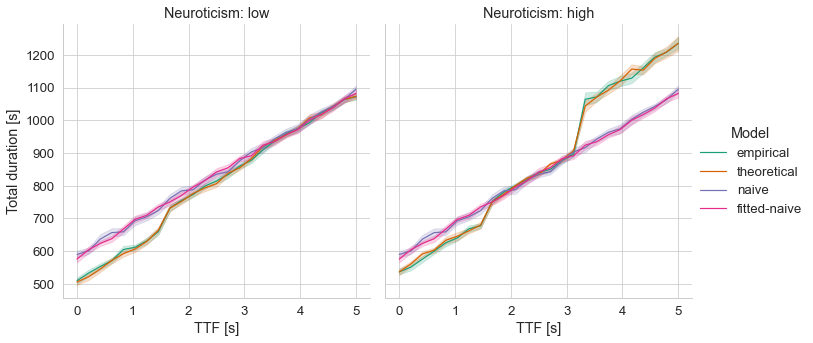

In [4]:
_end_steps = end_steps.copy()

_end_steps["neuro_group"] = "low"
_end_steps.loc[end_steps["neuroticism"] == "high", "neuro_group"] = "high"

na_data = _end_steps.loc[_end_steps["neuroticism"] == "n/a"].copy()
na_data["neuro_group"] = "high"
_end_steps = pd.concat((_end_steps, na_data), ignore_index=True)
_end_steps["neuro_group"] = _end_steps["neuro_group"].astype(pd.CategoricalDtype(["low", "high"], ordered=True))


fg = sns.relplot(
    kind="line",
    data=_end_steps,
    # err_style="bars",
    x="ttf",
    y="cumulative_duration",
    # style="model",
    hue="model",
    col="neuro_group",
    hue_order=["empirical", "theoretical", "naive", "fitted-naive",],
    # hue="neuroticism",
    # col="reference",
    # hue_order=["low", "high", "n/a"],
    # markers=["v", "^", "X"],
    markersize=7,
)
fg.set_axis_labels("TTF [s]", "Total duration [s]")
fg.set_titles("Neuroticism: {col_name}", "")
fg.legend.set_title("Model")
# fg.set(yscale="log")
plt.show()

del _end_steps

In [5]:
max_durations = end_steps[end_steps.ttf == end_steps.ttf.max()].groupby(["model", "neuroticism"], observed=True)["cumulative_duration"].mean()
(max_durations - max_durations[("fitted-naive", "n/a")])/max_durations[("fitted-naive", "n/a")]

model         neuroticism
empirical     low           -0.009505
              high           0.141710
fitted-naive  n/a            0.000000
naive         n/a            0.012317
theoretical   low           -0.008122
              high           0.141757
Name: cumulative_duration, dtype: float64

In [6]:
min_durations = end_steps[end_steps.ttf == end_steps.ttf.min()].groupby(["model", "neuroticism"], observed=True)["cumulative_duration"].mean()
(min_durations - min_durations[("fitted-naive", "n/a")])/min_durations[("fitted-naive", "n/a")]

model         neuroticism
empirical     low           -0.114935
              high          -0.067866
fitted-naive  n/a            0.000000
naive         n/a            0.024978
theoretical   low           -0.122194
              high          -0.068178
Name: cumulative_duration, dtype: float64

In [7]:
ix = pd.IndexSlice

duration_table = end_steps[(end_steps.ttf == end_steps.ttf.max()) | (end_steps.ttf == end_steps.ttf.min())][["model", "neuroticism", "ttf", "cumulative_duration"]]
duration_table = duration_table.groupby(["model", "neuroticism", "ttf"], observed=True).mean()
duration_table["diff"] = 0.0

def get_diff(s: pd.Series) -> pd.Series:
    ref = s.droplevel(-1)[("fitted-naive", "n/a")]
    return ((s - ref) / ref) * 100.0


duration_table["diff"] = duration_table.groupby("ttf")["cumulative_duration"].apply(get_diff)
duration_table.index.names = ["Model", "Neuroticism", r"\ac{TTF}"]
duration_table = duration_table.rename(columns={"cumulative_duration": "Total Duration", "diff": "Diff. w.r.t. fitted-naive"}).stack()
table_fmt = (
    duration_table
    .loc[
        ix[["fitted-naive", "empirical", "theoretical"]], :
    ]
    .unstack(level=-2)
    .unstack(level=-1)
    .style.format(lambda e: r"\SI{" f"{e:.2f}" r"}{\second}")
    .format(lambda e: ("" if e < 0 else "+") + r"\SI{" f"{e:.2f}" r"}{\percent}",  subset=ix[:, ix[:, "Diff. w.r.t. fitted-naive"]])
)# duration_table.style.format()
# print(duration_table.unstack(level=-2).unstack(level=-1).style.to_latex(siunitx=True))
table_fmt

In [8]:
print(table_fmt.to_latex(siunitx=True, hrules=True, column_format="llrrrr", ))

\begin{tabular}{llrrrr}
\toprule
{} & {\ac{TTF}} & \multicolumn{2}{r}{0.000000} & \multicolumn{2}{r}{5.000000} \\
{} & {} & {Total Duration} & {Diff. w.r.t. fitted-naive} & {Total Duration} & {Diff. w.r.t. fitted-naive} \\
{Model} & {Neuroticism} & {} & {} & {} & {} \\
\midrule
fitted-naive & n/a & \SI{575.54}{\second} & +\SI{0.00}{\percent} & \SI{1082.28}{\second} & +\SI{0.00}{\percent} \\
\multirow[c]{2}{*}{empirical} & low & \SI{509.39}{\second} & \SI{-11.49}{\percent} & \SI{1071.99}{\second} & \SI{-0.95}{\percent} \\
 & high & \SI{536.48}{\second} & \SI{-6.79}{\percent} & \SI{1235.65}{\second} & +\SI{14.17}{\percent} \\
\multirow[c]{2}{*}{theoretical} & low & \SI{505.22}{\second} & \SI{-12.22}{\percent} & \SI{1073.49}{\second} & \SI{-0.81}{\percent} \\
 & high & \SI{536.31}{\second} & \SI{-6.82}{\percent} & \SI{1235.70}{\second} & +\SI{14.18}{\percent} \\
\bottomrule
\end{tabular}



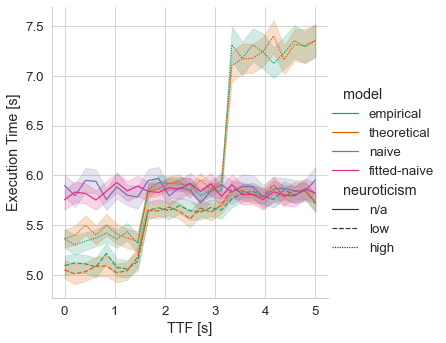

In [9]:
fg = sns.relplot(
    kind="line",
    data=results,
    x="ttf",
    y="exec_time",
    hue="model",
    hue_order=["empirical", "theoretical", "naive", "fitted-naive"],
    style="neuroticism",
)
fg.set_axis_labels("TTF [s]", "Execution Time [s]")
plt.show()

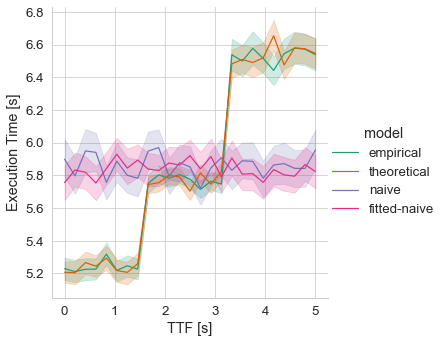

In [10]:
fg = sns.relplot(
    kind="line",
    data=results,
    x="ttf",
    y="exec_time",
    hue="model",
    hue_order=["empirical", "theoretical", "naive", "fitted-naive"],
    # style="neuroticism",
)
fg.set_axis_labels("TTF [s]", "Execution Time [s]")
plt.show()